In [1]:
import pandas as pd
import numpy as np
import MySQLdb as my
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups

import nltk
#nltk.download()
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import sys
#reload(sys)
#sys.setdefaultencoding('utf-8')

In [2]:
def load_db():
    fname="../dbcreds.dat" 
    f = open(fname,"r")
    #rstrip() is needde here or else it includse the newline from the creds file
    dbhost = f.readline().split(' ')[1].rstrip()
    dbuser = f.readline().split(' ')[1].rstrip()
    dbpw = f.readline().split(' ')[1].rstrip()
    dbdb = f.readline().split(' ')[1].rstrip()
    f.close()

    db = my.connect(host=dbhost,
            user=dbuser,
            passwd=dbpw,
            db=dbdb,
           #use_unicode=True, 
           # charset="utf8"
            )
    return db

In [3]:
# Over Single Month Period (30 days)
db = load_db()
cursor = db.cursor()
#date_from = '\'2018-01-31\''
#date_to = '\'2018-02-31\'' 
# Fix this naming
#sql = 'select lower(blurb),date from article_url where date <= ' +  date_to   + ' and >= ' + date_from
sql = 'select lower(blurb),date from article_url where date <=  "2018-03-31"  and date >= "2018-02-31"     '
cursor.execute(sql)
blurb_date_list = list(cursor.fetchall())

db.close()

In [4]:
#df = pd.read_sql('select lower(blurb),date from article_url where date = "2018-01-01"', con=db)
#for blurb,date in blurb_date_list:
    

In [5]:
#print df

In [6]:
date_freq = {}
target = 'trump'
for blurb,date in blurb_date_list:
    if target in blurb:
        if date in date_freq:
            date_freq[date] += 1
        else:
            date_freq[date] = 0
#rint date_freq

In [7]:
# https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
# Avoiding 'ValueError: If using all scalar values, you must pass an index' error
# Need to do reset index based on this in order to assign new column names we can pass into seaborn later 
# https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
trump_df = pd.Series(date_freq).to_frame().reset_index()
trump_df.columns = ['date','freq']
#print trump_df

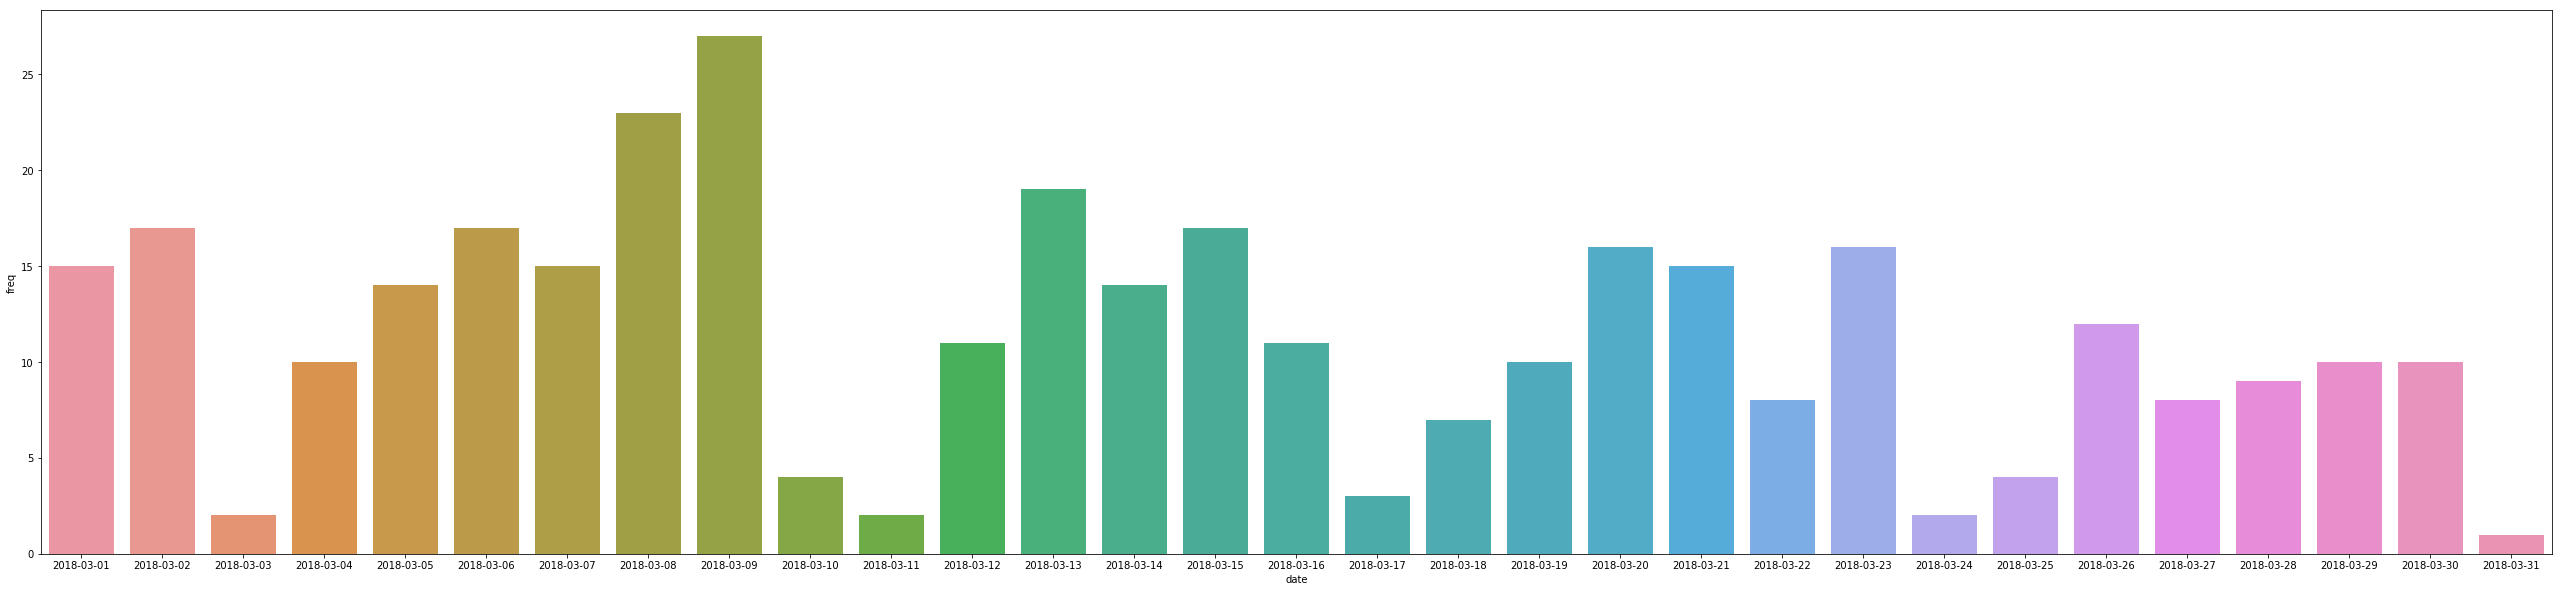

In [8]:
plt.figure(figsize=(45,10))
ax = sns.barplot(x="date", y="freq", data=trump_df)
#plt.savefig('2_trump_freq.pdf')

In [9]:
#Over Entire Year

db = load_db()
cursor = db.cursor()
sql = 'select lower(blurb),date from article_url'
cursor.execute(sql)
blurb_date_list = list(cursor.fetchall())
db.close()

In [10]:
date_freq = {}
target = 'oil'
for blurb,date in blurb_date_list:
    if target in blurb:
        if date.month in date_freq:
            date_freq[date.month] += 1
        else:
            date_freq[date.month] = 0
#rint date_freq

In [11]:
# https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
# Avoiding 'ValueError: If using all scalar values, you must pass an index' error
# Need to do reset index based on this in order to assign new column names we can pass into seaborn later 
# https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
trump_df = pd.Series(date_freq).to_frame().reset_index()
trump_df.columns = ['month','freq']
#print trump_df

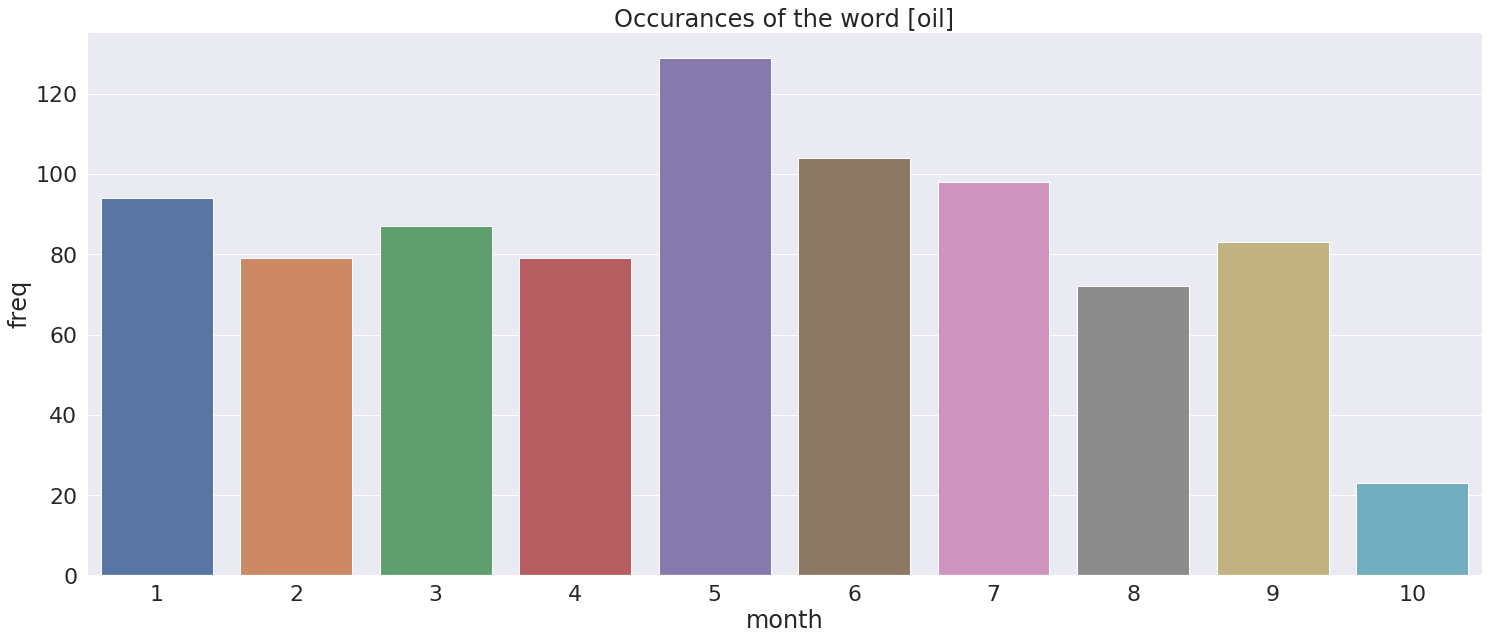

In [12]:

plt.figure(figsize=(25,10))
sns.set(font_scale = 2)
ax = sns.barplot(x="month", y="freq", data=trump_df).set_title('Occurances of the word [' + target + ']')
plt.savefig('../results/' + target + '_year_freq.pdf')

## Word2Vec 

In [13]:
blurb_list = []
for blurb,date in blurb_date_list:
    blurb_list.append(blurb)

In [14]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]


In [16]:
sentences = [line for text in blurb_list for line in clean(text)]

In [17]:
model = Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

In [38]:
print (model.wv.most_similar('india'))

[('ambitions', 0.7835991382598877), ('huawei', 0.7609796524047852), ('southeast', 0.7599151134490967), ('australia', 0.7420903444290161), ('boeing', 0.7301806807518005), ('arabia', 0.7286550998687744), ('airbus', 0.7195889949798584), ('britain', 0.7166763544082642), ('ship', 0.7099316120147705), ('atlantic', 0.7094730138778687)]


In [43]:
#TODO(shelbyt): For some reason this always shows a different graph.
X = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

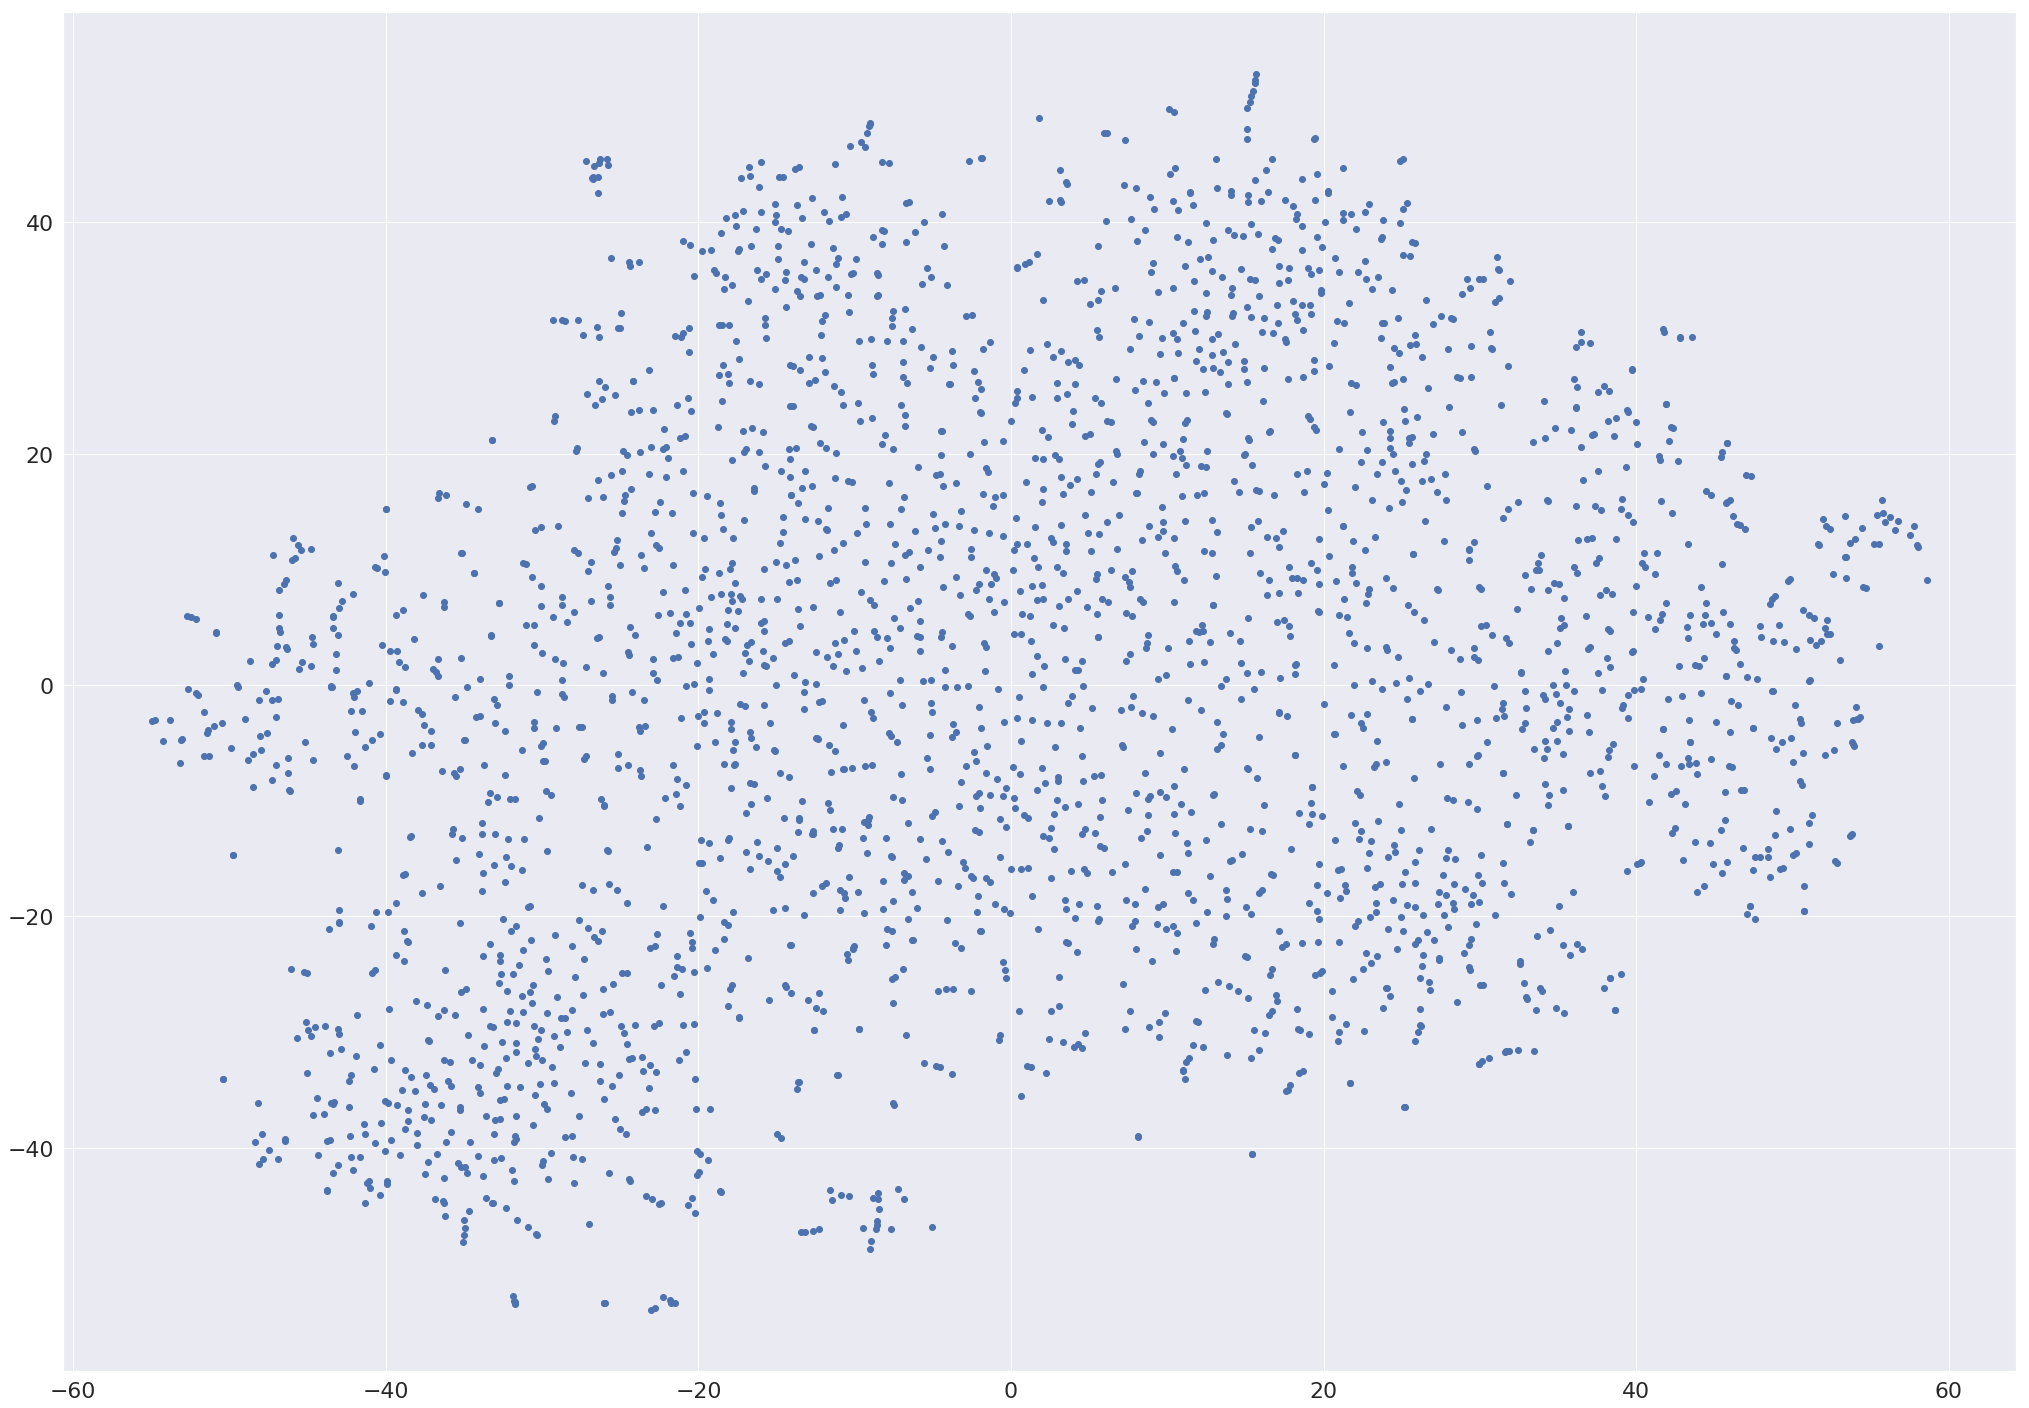

In [47]:
plt.figure(figsize=(35,25))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])